<a href="https://colab.research.google.com/github/vsinyutsina/hft_final_qw/blob/main/%D0%9E%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B5%D0%B9_%5B%D0%A7%D0%B0%D1%81%D1%82%D1%8C_1%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt

In [3]:
df_hft = pd.read_csv('hft_data.csv')
df_hft.head()

,Datetime,Close,High,Low,Open,Volume,share_name,ticker_name
0,2025-02-03 14:30:00+00:00,410.720001,411.980011,409.119995,411.760010,1942143.0,Microsoft,MSFT
1,2025-02-03 14:31:00+00:00,411.290009,411.500000,410.000000,410.734985,174765.0,Microsoft,MSFT
2,2025-02-03 14:32:00+00:00,413.320007,413.320007,411.399994,411.399994,174173.0,Microsoft,MSFT
3,2025-02-03 14:33:00+00:00,412.850006,413.950012,412.850006,413.269989,162649.0,Microsoft,MSFT
4,2025-02-03 14:34:00+00:00,412.934998,413.160004,412.630005,412.804993,120189.0,Microsoft,MSFT


In [4]:
df_hft['Datetime'] = pd.to_datetime(df_hft['Datetime'])
df_hft['Datetime'] = df_hft['Datetime'].dt.tz_convert(None)

In [5]:
shares = {
            'Microsoft': 'MSFT',
            'Apple': 'AAPL',
            'NVIDIA': 'NVDA',
            'Amazon': 'AMZN',
            'Alphabet': 'GOOG',
            'Tesla': 'TSLA',
            'Broadcom': 'AVGO',
            'Meta': 'META',
            'Costco': 'COST',
            'Netflix': 'NFLX'
        }
crypto = {
            'Bitcoin': 'BTC',
            'Ethereum': 'ETH',
            'Tether': 'USDT',
            'Binance': 'BNB',
            'Solana': 'SOL',
            'USD': 'USDC',
            'XRP': 'XRP',
            'Cardano': 'ADA',
            'Dogecoin': 'DOGE',
            'Toncoin': 'TON'
        }

In [6]:
df_shares = pd.DataFrame(shares.items(), columns=['share_name', 'ticker_name'])
df_crypto = pd.DataFrame(crypto.items(), columns=['share_name', 'ticker_name'])

df_shares = pd.concat([df_shares, df_crypto])
df_shares['key'] = 1
df_shares.head()

,share_name,ticker_name,key
0,Microsoft,MSFT,1
1,Apple,AAPL,1
2,NVIDIA,NVDA,1
3,Amazon,AMZN,1
4,Alphabet,GOOG,1


In [7]:
start = datetime(2025, 2, 1)
end = datetime(2025, 3, 1)
delta = timedelta(minutes=1)

date_list = [start + i * delta for i in range(int((end - start) / delta) + 1)]

df_calendar = pd.DataFrame(date_list, columns=['Datetime'])
df_calendar['key'] = 1
df_calendar.head()

,Datetime,key
0,2025-02-01 00:00:00,1
1,2025-02-01 00:01:00,1
2,2025-02-01 00:02:00,1
3,2025-02-01 00:03:00,1
4,2025-02-01 00:04:00,1


In [8]:
df_calendar = df_calendar.merge(df_shares, on='key')
df_calendar = df_calendar.drop('key', axis=1)

In [9]:
df_calendar.head()

,Datetime,share_name,ticker_name
0,2025-02-01,Microsoft,MSFT
1,2025-02-01,Apple,AAPL
2,2025-02-01,NVIDIA,NVDA
3,2025-02-01,Amazon,AMZN
4,2025-02-01,Alphabet,GOOG


# Подготовка данных к обучению

In [10]:
df = df_calendar.merge(df_hft, how='left', on=['Datetime', 'share_name', 'ticker_name'])

df['Date'] = df.Datetime.dt.date
df = df.loc[df['Date'] > date(2025, 2, 3), :]
df.head()

,Datetime,share_name,ticker_name,Close,High,Low,Open,Volume,Date
86400,2025-02-04,Microsoft,MSFT,NaN,NaN,NaN,NaN,NaN,2025-02-04
86401,2025-02-04,Apple,AAPL,NaN,NaN,NaN,NaN,NaN,2025-02-04
86402,2025-02-04,NVIDIA,NVDA,NaN,NaN,NaN,NaN,NaN,2025-02-04
86403,2025-02-04,Amazon,AMZN,NaN,NaN,NaN,NaN,NaN,2025-02-04
86404,2025-02-04,Alphabet,GOOG,NaN,NaN,NaN,NaN,NaN,2025-02-04


## Заполняем пропуски в данных

In [11]:
df = df.sort_values(['ticker_name', 'Datetime'])

df['Close'] = df.groupby('ticker_name')['Close'].ffill().bfill()
df['High'] = df.groupby('ticker_name')['Close'].ffill().bfill()
df['Low'] = df.groupby('ticker_name')['Close'].ffill().bfill()
df['Open'] = df.groupby('ticker_name')['Close'].ffill().bfill()
df['working_hours'] = 1
df.loc[df['Volume'].isna(), 'working_hours'] = 0
df.loc[df['Volume'].isna(), 'Volume'] = 0

In [12]:
df = df[~df.Close.isna()] #Отсекаем все, что не заполнилось, потому что там и нечему заполняться
df.reset_index(inplace=True, drop=True)

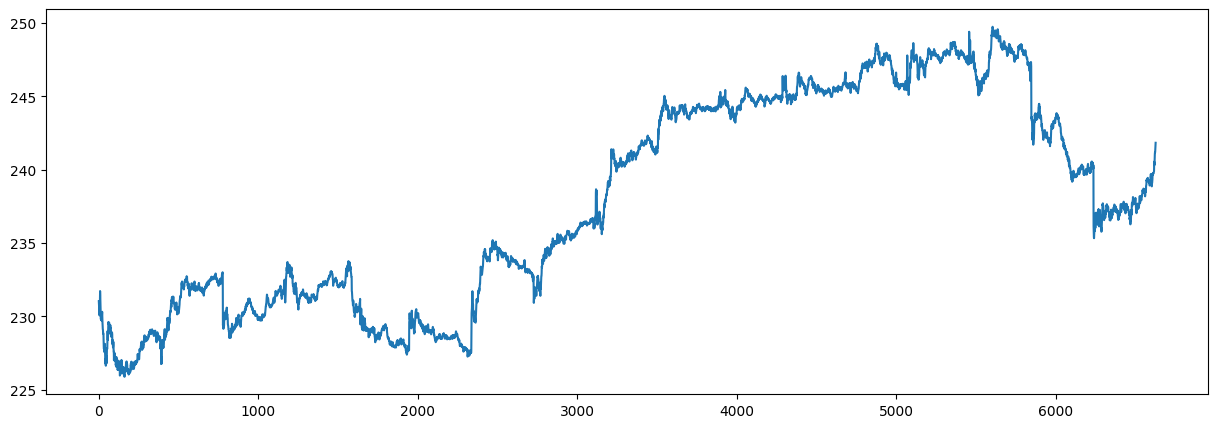

In [13]:
# График, если убрать дни, когда биржа не работала
plt.figure(figsize=(15, 5))

plt.plot(df_hft.query('(share_name == "Apple")').reset_index().Close)

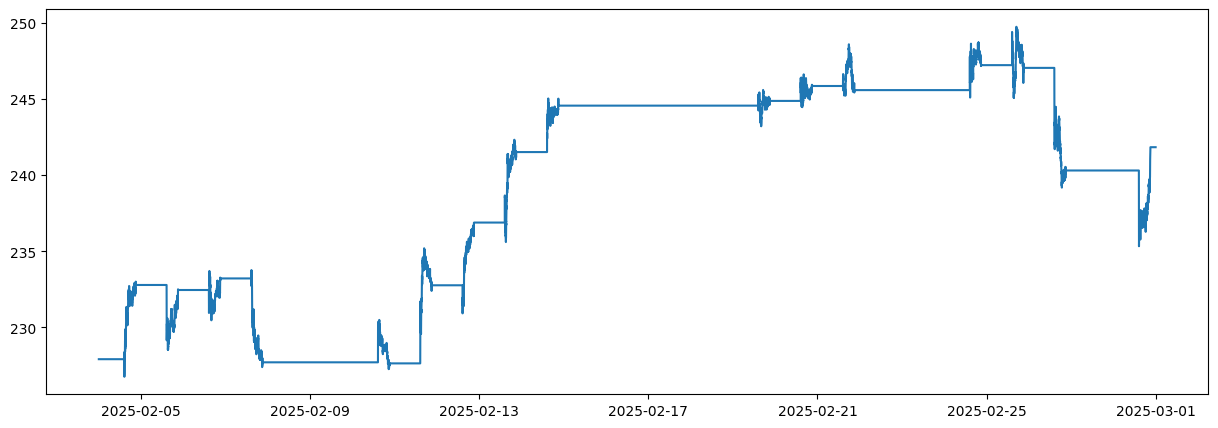

In [14]:
# График, если НЕ убирать дни, когда биржа не работала

plt.figure(figsize=(15, 5))

plt.plot(df.query('(share_name == "Apple")').set_index('Datetime').Close)

Как будто датафрейм с обработанными выбросами не стоит использовать для обучения модели. Предлагаю обучаться на данных без привязки к дате. Важно сохранить именно последовательность.

## Добавляем таргет к датафрейму

In [15]:
df_hft['Close_prev'] = df_hft.groupby(['share_name', 'ticker_name']).Close.shift(1)
df = df_hft[~df_hft.Close_prev.isna()]

df = df.copy()
df['target_abs'] = df['Close'] - df['Close_prev']
df['target_ratio'] = df['target_abs']/df['Close_prev']
df.head()

,Datetime,Close,High,Low,Open,Volume,share_name,ticker_name,Close_prev,target_abs,target_ratio
1,2025-02-03 14:31:00,411.290009,411.500000,410.000000,410.734985,174765.0,Microsoft,MSFT,410.720001,0.570007,0.001388
2,2025-02-03 14:32:00,413.320007,413.320007,411.399994,411.399994,174173.0,Microsoft,MSFT,411.290009,2.029999,0.004936
3,2025-02-03 14:33:00,412.850006,413.950012,412.850006,413.269989,162649.0,Microsoft,MSFT,413.320007,-0.470001,-0.001137
4,2025-02-03 14:34:00,412.934998,413.160004,412.630005,412.804993,120189.0,Microsoft,MSFT,412.850006,0.084991,0.000206
5,2025-02-03 14:35:00,414.121613,414.399994,412.649994,413.029999,245168.0,Microsoft,MSFT,412.934998,1.186615,0.002874


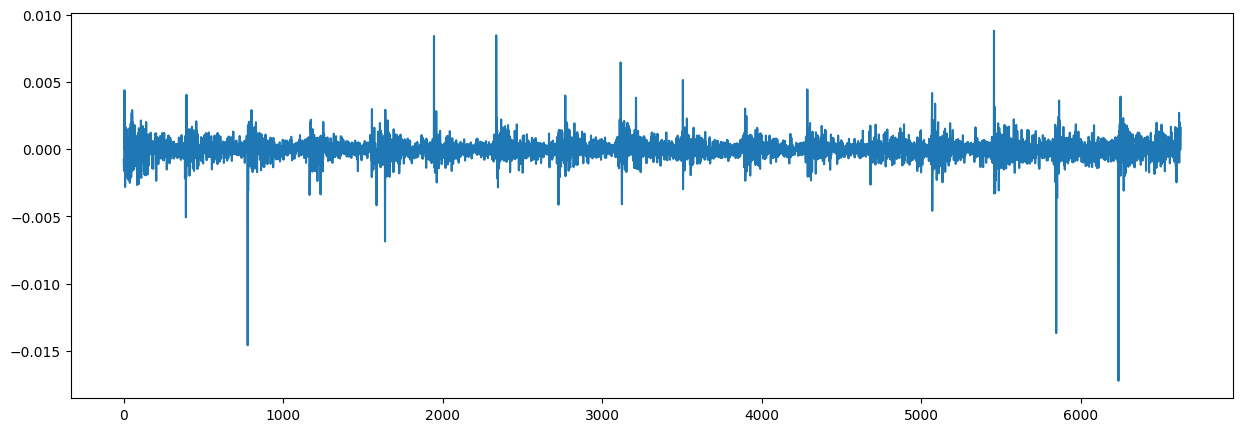

In [16]:
plt.figure(figsize=(15, 5))

plt.plot(df.query('(share_name == "Apple")').reset_index().target_ratio)

## Трейн и тест

In [17]:
def train_test_series_split(series, test_size=0.2):

    train_size = int(len(series) * (1 - test_size))
    train, test = series[:train_size], series[train_size:]

    return train, test

# Обучение простых моделей
## Статистические модели
### SARIMAX

In [18]:
# Функция для обучения и прогнозирования SARIMAX для одного ряда
def train_and_predict_sarimax(series, order, seasonal_order, test_size=0.2):

    train, test = train_test_series_split(series, test_size=0.2)

    model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)  # disp=False для подавления вывода
    predictions = model_fit.forecast(steps=len(test))
    rmse = sqrt(mean_squared_error(test, predictions))

    return predictions, rmse

In [19]:
# # Группируем данные по ticker_name
# grouped = df.groupby('ticker_name')['target_ratio']

# # Создаем словарь для хранения результатов
# results = {}

# order = (1, 1, 0)
# seasonal_order = (1, 1, 0, 60)

# # Итерируемся по каждой группе (акции) и обучаем модель
# for ticker, series in grouped:
#     print(f"Обучение модели для {ticker}...")
#     predictions, rmse = train_and_predict_sarimax(series, order, seasonal_order)
#     results[ticker] = {'predictions': predictions, 'rmse': rmse}
#     print(f"RMSE для {ticker}: {rmse:.4f}")
#     print("-" * 20)

In [21]:
# df_result = pd.DataFrame([(ticker, result['rmse']) for ticker, result in results.items()], columns=['ticker_name', 'rmse_sarimax'])
# df_result

In [22]:
# df_result.to_csv('df_result.csv', index=False)
df_result = pd.read_csv('df_result.csv')
df_result

,ticker_name,rmse_sarimax
0,AAPL,0.001730
1,AMZN,0.004263
2,AVGO,0.006370
3,BTC,0.005152
4,COST,0.006334
5,ETH,0.005232
6,GOOG,0.001420
7,META,0.002923
8,MSFT,0.001892
9,NFLX,0.009401


## Классический ML
### Генерируем новые признаки

In [23]:
df_classic = df.copy()
df_classic = df_classic.query('ticker_name != "USDC"')

df_classic['target'] = df_classic.groupby('ticker_name').target_ratio.shift(-1)
df_classic.head()

,Datetime,Close,High,Low,Open,Volume,share_name,ticker_name,Close_prev,target_abs,target_ratio,target
1,2025-02-03 14:31:00,411.290009,411.500000,410.000000,410.734985,174765.0,Microsoft,MSFT,410.720001,0.570007,0.001388,0.004936
2,2025-02-03 14:32:00,413.320007,413.320007,411.399994,411.399994,174173.0,Microsoft,MSFT,411.290009,2.029999,0.004936,-0.001137
3,2025-02-03 14:33:00,412.850006,413.950012,412.850006,413.269989,162649.0,Microsoft,MSFT,413.320007,-0.470001,-0.001137,0.000206
4,2025-02-03 14:34:00,412.934998,413.160004,412.630005,412.804993,120189.0,Microsoft,MSFT,412.850006,0.084991,0.000206,0.002874
5,2025-02-03 14:35:00,414.121613,414.399994,412.649994,413.029999,245168.0,Microsoft,MSFT,412.934998,1.186615,0.002874,-0.001235


**Список новых признаков:**
1. Временные признаки
  - День
  - День недели
  - Минута
  - Час
2. Лаговые признаки
  - t-1, t-2, t-3, t-5, t-10, t-30, t-60
  - Скользящие средние (Moving Averages)
  - Отклонение от скользящей средней
  - Разности (Differences)
3. Статистические признаки (Statistical Features)
4. Fourier Transform Features


In [31]:
def calculate_fft_features(series, window_size):
    """
    Вычисляет признаки на основе FFT для скользящего окна.

    Args:
        series (pd.Series):  Временной ряд.
        window_size (int):  Размер скользящего окна.

    Returns:
        pd.DataFrame:  DataFrame с признаками (амплитуды и фазы).
    """

    amplitudes_list = []
    phases_list = []

    for i in range(len(series) - window_size + 1):
        window = series[i:i + window_size].values
        windowed = window * np.hanning(window_size) # Применение оконной функции
        fft = np.fft.fft(windowed)
        fft_abs = np.abs(fft)
        fft_angle = np.angle(fft)

        amplitudes_list.append(fft_abs)
        phases_list.append(fft_angle)


    # Преобразование списков NumPy массивов в DataFrame
    df = pd.DataFrame()
    df['amplitudes'] = amplitudes_list
    df['phases'] = phases_list

    return df

In [57]:
def new_time_features(data):
  data['minute'] = data.Datetime.dt.minute
  data['hour'] = data.Datetime.dt.hour
  data['day'] = data.Datetime.dt.day
  data['weekday'] = data.Datetime.dt.weekday

  d_time = [('minute', 60), ('hour', 24), ('day', 31), ('weekday', 7)]

  for col_name, period in d_time:
    data[col_name + '_sin'] = np.sin(2 * np.pi * data[col_name] / period)
    data[col_name + '_cos'] = np.cos(2 * np.pi * data[col_name] / period)
    data[col_name] = data[col_name].apply(str)

  return data


def new_lag_and_statistic_features(data):
  lags = [1, 2, 3, 5, 15, 30, 60]

  for lag in lags:
    data['ratio_lag_' + str(lag)] = data.target_ratio.shift(lag)
    data['ratio_diff_lag_' + str(lag)] = data.target_ratio - data['ratio_lag_' + str(lag)]
    data['ratio_mean_lag_' + str(lag)] = data.groupby('ticker_name').target_ratio.transform(lambda x: x.rolling(lag, min_periods=1).mean())
    data['ratio_diff_mean_lag_' + str(lag)] = data.target_ratio - data['ratio_mean_lag_' + str(lag)]
    data['ratio_exp_mean_lag_' + str(lag)] = data.groupby('ticker_name').target_ratio.transform(lambda x: x.ewm(alpha=lag/100, min_periods=1).mean())

  for lag in lags[3:]:
    data['ratio_max_lag_' + str(lag)] = data.groupby('ticker_name').target_ratio.transform(lambda x: x.rolling(lag, min_periods=1).max())
    data['ratio_min_lag_' + str(lag)] = data.groupby('ticker_name').target_ratio.transform(lambda x: x.rolling(lag, min_periods=1).min())
    data['ratio_q25_lag_' + str(lag)] = data.groupby('ticker_name').target_ratio.transform(lambda x: x.rolling(lag, min_periods=1).quantile(0.25))
    data['ratio_q75_lag_' + str(lag)] = data.groupby('ticker_name').target_ratio.transform(lambda x: x.rolling(lag, min_periods=1).quantile(0.75))

  return data


def new_fft_features(data):

  grouped = data.groupby('ticker_name').target_ratio
  lags = [5, 15, 30, 60]
  res = []
  for ticker, series in grouped:

    for lag in lags:
      tmp = calculate_fft_features(series, lag)
      res.append((ticker, tmp))

  return res

In [58]:
df_classic = new_time_features(df_classic)
df_classic.head()

,Datetime,Close,High,Low,Open,Volume,share_name,ticker_name,Close_prev,target_abs,...,hour_cos,day_sin,day_cos,weekday_sin,weekday_cos,ratio_lag_1,ratio_diff_lag_1,ratio_mean_lag_5,ratio_mean_lag_1,ratio_diff_mean_lag_1
1,2025-02-03 14:31:00,411.290009,411.500000,410.000000,410.734985,174765.0,Microsoft,MSFT,410.720001,0.570007,...,-0.866025,0.571268,0.820763,0.0,1.0,NaN,NaN,NaN,0.001388,0.0
2,2025-02-03 14:32:00,413.320007,413.320007,411.399994,411.399994,174173.0,Microsoft,MSFT,411.290009,2.029999,...,-0.866025,0.571268,0.820763,0.0,1.0,0.001388,0.003548,NaN,0.004936,0.0
3,2025-02-03 14:33:00,412.850006,413.950012,412.850006,413.269989,162649.0,Microsoft,MSFT,413.320007,-0.470001,...,-0.866025,0.571268,0.820763,0.0,1.0,0.004936,-0.006073,NaN,-0.001137,0.0
4,2025-02-03 14:34:00,412.934998,413.160004,412.630005,412.804993,120189.0,Microsoft,MSFT,412.850006,0.084991,...,-0.866025,0.571268,0.820763,0.0,1.0,-0.001137,0.001343,NaN,0.000206,0.0
5,2025-02-03 14:35:00,414.121613,414.399994,412.649994,413.029999,245168.0,Microsoft,MSFT,412.934998,1.186615,...,-0.866025,0.571268,0.820763,0.0,1.0,0.000206,0.002668,NaN,0.002874,0.0


In [60]:
df_classic = new_lag_and_statistic_features(df_classic)
df_classic.head()

,Datetime,Close,High,Low,Open,Volume,share_name,ticker_name,Close_prev,target_abs,...,ratio_q25_lag_15,ratio_q75_lag_15,ratio_max_lag_30,ratio_min_lag_30,ratio_q25_lag_30,ratio_q75_lag_30,ratio_max_lag_60,ratio_min_lag_60,ratio_q25_lag_60,ratio_q75_lag_60
1,2025-02-03 14:31:00,411.290009,411.500000,410.000000,410.734985,174765.0,Microsoft,MSFT,410.720001,0.570007,...,0.001388,0.001388,0.001388,0.001388,0.001388,0.001388,0.001388,0.001388,0.001388,0.001388
2,2025-02-03 14:32:00,413.320007,413.320007,411.399994,411.399994,174173.0,Microsoft,MSFT,411.290009,2.029999,...,0.002275,0.004049,0.004936,0.001388,0.002275,0.004049,0.004936,0.001388,0.002275,0.004049
3,2025-02-03 14:33:00,412.850006,413.950012,412.850006,413.269989,162649.0,Microsoft,MSFT,413.320007,-0.470001,...,0.000125,0.003162,0.004936,-0.001137,0.000125,0.003162,0.004936,-0.001137,0.000125,0.003162
4,2025-02-03 14:34:00,412.934998,413.160004,412.630005,412.804993,120189.0,Microsoft,MSFT,412.850006,0.084991,...,-0.000130,0.002275,0.004936,-0.001137,-0.000130,0.002275,0.004936,-0.001137,-0.000130,0.002275
5,2025-02-03 14:35:00,414.121613,414.399994,412.649994,413.029999,245168.0,Microsoft,MSFT,412.934998,1.186615,...,0.000206,0.002874,0.004936,-0.001137,0.000206,0.002874,0.004936,-0.001137,0.000206,0.002874


In [61]:
df_classic = new_fft_features(df_classic)